In [1]:
import numpy as np
from scipy.special import gamma
from scipy.special import comb
import matplotlib.pyplot as plt

# Binomial Distribution

$$Bin(m \vert N, \mu) = \begin{pmatrix}N \\ m\end{pmatrix}\mu^m(1-\mu)^{N-m}$$

* likelihood: what parameter is likely to be to explain the observed data
* change $N$ to $l+m$

$$\begin{aligned}L(\mu) &= Bin(\mu \vert m, l) \\
&=\begin{pmatrix} l+m \\ m\end{pmatrix}\mu^m(1-\mu)^l
\end{aligned}$$


## MLE

In [1]:

def Binomial(mu, n, m):
    """
    mu: probability
    n: number of trials
    m: counts of random variable X is 1
    """
    return comb(n, m) * (mu**m) * (1-mu)**(n-m)

probs = np.linspace(0, 1, num=50)
N = 7
X = np.arange(0, N+1)

fig, axes = plt.subplots(2, (N+1)//2, figsize=(20, 10), sharey=True)
for x, ax in zip(X, axes.flatten()):
    L = Binomial(probs, N, x)
    max_y, max_x = L.max(), probs[L.argmax()]
    ax.plot(probs, L)
    ax.scatter(max_x, max_y, s=20, c="red")
    ax.set_title(f"N={N}, X={x}")
plt.tight_layout()
plt.show()


<Figure size 2000x1000 with 8 Axes>

$$Beta(\mu \vert a, b)=\dfrac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\mu^{a-1}(1-\mu)^{b-1}$$

gamma function

$$\Gamma(x)=\int_0^{\infty}u^{x-1}e^{-u}du$$

In [2]:
def Beta(mu, a, b):
    return gamma(a + b)/(gamma(a)*gamma(b)) * mu**(a-1) * (1-mu)**(b-1)

/home/simonjisu/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


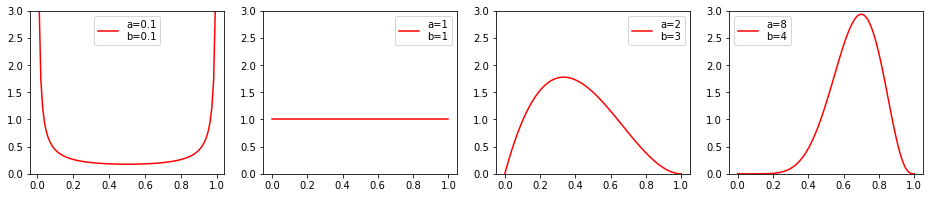

In [3]:
aa = [0.1, 1, 2, 8]
bb = [0.1, 1, 3, 4]
probs = np.linspace(0, 1, num=100)

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
for ax, a, b in zip(axes, aa, bb):
    beta_value = Beta(probs, a, b)
    ax.plot(probs, beta_value, c="red", label=f"a={a}\nb={b}")
    ax.set_ylim(0, 3)
    ax.legend()

$$\text{posterior} \propto \text{likelihood}\times \text{prior}$$

$$p(\mu \vert m, l, a, b) = L(\mu \vert m, l) \times Beta(\mu \vert a, b)$$

In [4]:
def Posterior(theta, m, l, a, b):
    return gamma(m+a+l+b)/(gamma(m+a)*gamma(l+b))*theta**(m+a-1)*(1-theta)**(l+b-1)

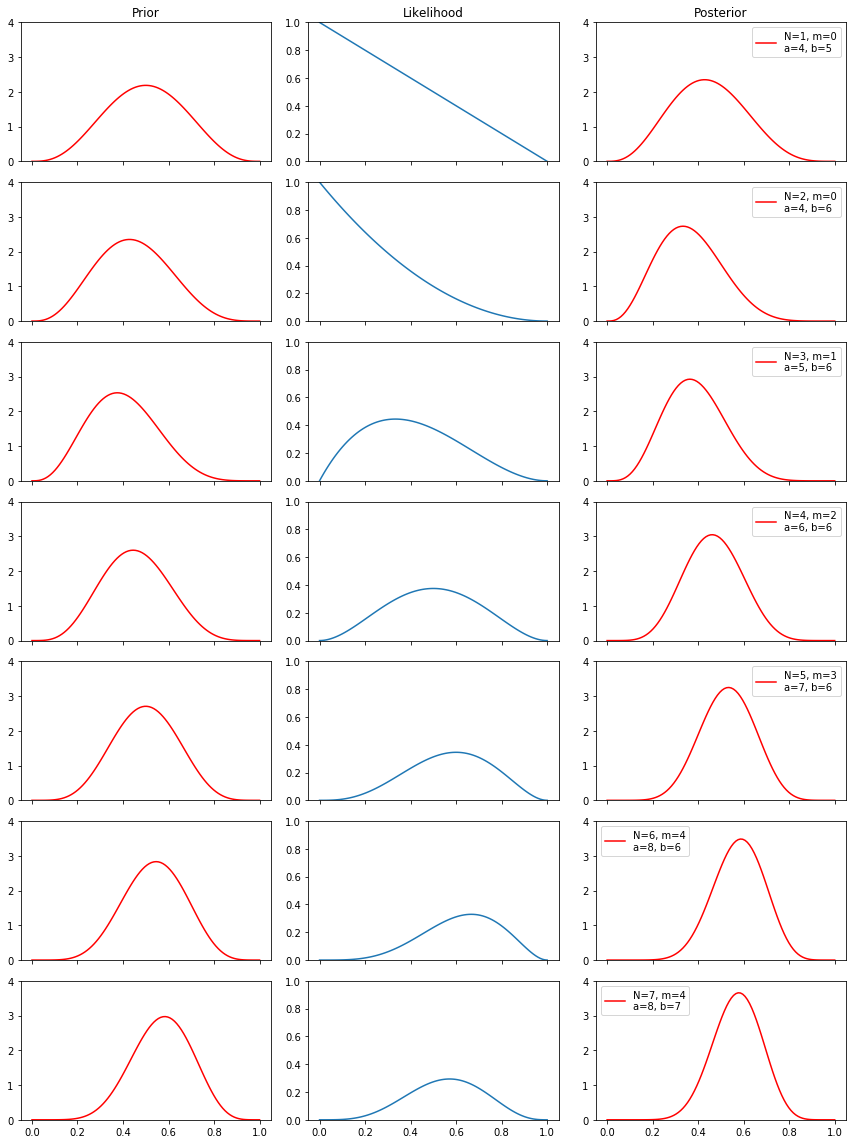

In [7]:
a, b = (4, 4)  # init hyperparameters

X = np.array([0, 0, 1, 1, 1, 1, 0])  # observed data
probs = np.linspace(0, 1, num=100)
fig, axes = plt.subplots(len(X), 3, figsize=(12, 16), sharex=True, sharey=False)

# online update?
m = 0
for i, (x, row_axes) in enumerate(zip(X, axes)):
    if x == 1:
        m += 1
    likelihood = Binomial(probs, i+1, m)
    prior = Beta(probs, a, b)
    post = Posterior(probs, m, (i+1)-m, a, b)
    if x == 1:
        a += 1
    else:
        b += 1
        
    # draw
    if i == 0:
        row_axes[0].set_title("Prior")
        row_axes[1].set_title("Likelihood")
        row_axes[2].set_title("Posterior")
    row_axes[0].plot(probs, prior, c="red")
    row_axes[1].plot(probs, likelihood)
    row_axes[2].plot(probs, post, c="red", label=f"N={i+1}, m={m}\na={a}, b={b}")
    row_axes[0].set_ylim(0, 4)
    row_axes[1].set_ylim(0, 1)
    row_axes[2].set_ylim(0, 4)
    row_axes[2].legend()
plt.tight_layout()
plt.show()

## Gaussian Distribution

* single variable

$$\mathcal{N}(x \vert \mu, \sigma^2)=\dfrac{1}{(2\pi \sigma^2)^{1/2}} \exp \big\{-\dfrac{1}{2\sigma^2}(x-\mu)^2\big\}$$

* multi variables

$$\begin{aligned} \mathcal{N}(x \vert \mu, \Sigma^2) &=\dfrac{1}{(2\pi)^{D/2}} \dfrac{1}{\vert\Sigma\vert^{1/2}} \exp \big\{-\dfrac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big\} \\
&=\dfrac{1}{(2\pi)^{D/2}} \dfrac{1}{\vert\Sigma\vert^{1/2}} \exp \big\{-\Delta^2\big\} 
\end{aligned}$$



## How to calculate eigen vectors

In [12]:
A = np.array([[2, 3], [3, 5]])
eigen1, eigen2 = np.roots([1, -7, 1])
eigen1.round(2), eigen2.round(2)

(6.85, 0.15)

In [13]:
B1 = A - eigen1 * np.eye(2)
B2 = A - eigen2 * np.eye(2)
print(B1.round(2))
print()
print(B2.round(2))

[[-4.85  3.  ]
 [ 3.   -1.85]]

[[1.85 3.  ]
 [3.   4.85]]


In [22]:
temp = B1.copy()
# Row reduction:
# -R2[0]/R1[0] * R1 + R2 --> R2
temp[1, :] = (-B1[1, 0]/B1[0, 0])*B1[0, :] + B1[1, :]
print("After row reduction")
print(temp.round(2))

# eigen_vector relationship: 
# -4.85 * x_1 + 3 * x_2 = 0
# let x_1 = 1
x_1 = 1
x_2 = (-temp[0, 0] * x_1) / temp[0, 1]
eigen_v1 = np.array([[x_1], [x_2]])
print("eigen vector if eigen value is 6.85")
print(eigen_v1.round(2))

After row reduction
[[-4.85  3.  ]
 [ 0.   -0.  ]]
eigen vector if eigen value is 6.85
[[1.  ]
 [1.62]]


In [23]:
temp = B2.copy()
# Row reduction:
# -R2[0]/R1[0] * R1 + R2 --> R2
temp[1, :] = (-B2[1, 0]/B2[0, 0])*B2[0, :] + B2[1, :]
print("After row reduction")
print(temp.round(2))

# eigen_vector relationship: 
# 1.85 * x_1 + 3 * x_2 = 0
# let x_1 = 1
x_1 = 1
x_2 = (-temp[0, 0] * x_1) / temp[0, 1]
eigen_v2 = np.array([[x_1], [x_2]])
print("eigen vector if eigen value is 0.15")
print(eigen_v2.round(2))

After row reduction
[[1.85 3.  ]
 [0.   0.  ]]
eigen vector if eigen value is 0.15
[[ 1.  ]
 [-0.62]]


In [28]:
e_val = np.array((eigen2, eigen1))
e_vec = np.concatenate((eigen_v2, eigen_v1), axis=1) 
e_vec = e_vec / (np.linalg.norm(e_vec[:, 0]), np.linalg.norm(e_vec[:, 1]))  # noramlizing

print("Eigen value:")
print(e_val)
print("Eigen vector for each eigen value(column vector)")
print(e_vec)

Eigen value:
[0.14589803 6.85410197]
Eigen vector for each eigen value(column vector)
[[ 0.85065081  0.52573111]
 [-0.52573111  0.85065081]]


In [29]:
# same result as numpy "eig" function
e_val_np, e_vec_np = np.linalg.eig(A)
print("Eigen value:")
print(e_val_np)
print("Eigen vector for each eigen value(column vector)")
print(e_vec_np)

Eigen value:
[0.14589803 6.85410197]
Eigen vector for each eigen value(column vector)
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


In [98]:
# V: eigen vector matrix, L: eigen value only on diagonal term, *: dotproduct(only here)
# A*V = V*L
I = np.eye(2)
L = e_val*I
print("A*V")
print(A.dot(e_vec))
print()
print("V*L")
print(e_vec.dot(L))
print()

# which means that 
# A = V*L*V^{-1}
print("V*L*V^{-1}")
print(e_vec.dot(L).dot(np.linalg.inv(e_vec)))
print()
# Also "V^{-1} == V^T"
print("V^{-1} == V^T")
print(np.linalg.inv(e_vec).round(3) == e_vec.T.round(3))
print()

A*V
[[ 0.12410828  3.60341465]
 [-0.07670314  5.83044738]]

V*L
[[ 0.12410828  3.60341465]
 [-0.07670314  5.83044738]]

V*L*V^{-1}
[[2. 3.]
 [3. 5.]]

V^{-1} == V^T
[[ True  True]
 [ True  True]]



In [223]:
def draw_multi_gaussian(mu, cov, e_vec=None, n=5000, limits=None):
    """
    only for 2d
    n : sample size
    mag : magnitute for eigen vectors(eigen values, column vectors)
    limits : axis limits [0]: x-axis, [1]: y-axis
    """
    x = np.random.multivariate_normal(mean=mu, cov=cov, size=(n))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(x[:, 0], x[:, 1], c="g", s=10, alpha=0.3)
    if e_vec is not None:
        ax.arrow(*mu, *e_vec[:, 0], head_width=0.5, head_length=0.8, fc='r', ec='r')
        ax.arrow(*mu, *e_vec[:, 1], head_width=0.5, head_length=0.8, fc='r', ec='r')
    if limits is not None:
        ax.set_xlim(*limits[0])
        ax.set_ylim(*limits[1])
    plt.show()

[[0.14589803 0.        ]
 [0.         6.85410197]]


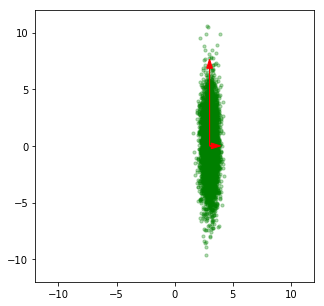

In [224]:
limits = [(-12, 12), (-12, 12)]

# in PRML they set the sigma very simple,
# let V = I (identity matrix)
# then, A = L, which means 0 for non diagonal terms
print(L)
mu = np.array([3, 0])
draw_multi_gaussian(mu, L, e_vec=L, limits=limits)

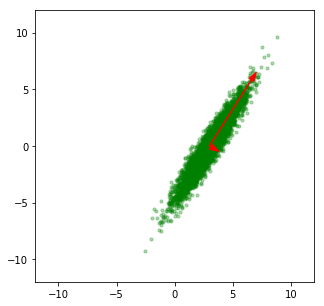

In [229]:
# this example: A
draw_multi_gaussian(mu, A, e_vec=e_vec.dot(L), limits=limits)

In [235]:
L

array([[0.14589803, 0.        ],
       [0.        , 6.85410197]])

---

In [234]:
(np.array([[1, 0]]).dot(np.array([[3, 4]])))

ValueError: shapes (1,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)

array([[0.12410828, 0.        ],
       [0.        , 0.        ]])

In [45]:
I[:, 0:1]

array([[1.],
       [0.]])

In [44]:
I[:, 0:1].dot(I[:, 0:1].T)

array([[1., 0.],
       [0., 0.]])

In [46]:
I[:, 1:2].dot(I[:, 1:2].T)

array([[0., 0.],
       [0., 1.]])

In [105]:
import sympy
sympy.Matrix(eigen_vector).rref()

(Matrix([
 [1, 0],
 [0, 1]]), (0, 1))

In [106]:
# RREF
X = eigen_vector.copy()
X

array([[-0.85065081, -0.52573111],
       [ 0.52573111, -0.85065081]])

In [107]:
# (X[0, 1]/X[0, 0])*R1 + R2 --> R2
X[1, :] = (X[0, 1]/X[0, 0])*X[0, :] + X[1, :]
X

array([[-0.85065081, -0.52573111],
       [ 0.        , -1.1755705 ]])

In [108]:
# (1/X[1, 1])*R2 --> R2
X[1, :] = (1/X[1, 1])*X[1, :]
X

array([[-0.85065081, -0.52573111],
       [-0.        ,  1.        ]])

In [109]:
# -X[0, 1]*R2 + R1 --> R1
X[0, :] = -X[0, 1]*X[1, :] + X[0, :]
X

array([[-0.85065081,  0.        ],
       [-0.        ,  1.        ]])

In [110]:
# (1/X[0, 0])*R1 --> R1
X[0, :] = (1/X[0, 0])*X[0, :]
X

array([[ 1., -0.],
       [-0.,  1.]])

In [114]:
a = eigen_vector[0, 1]/eigen_vector[0, 0]
b = eigen_vector[1, 1]/eigen_vector[1, 0]

In [120]:
A.dot(eigen_vector[:, 0:1])

array([[-0.12410828],
       [ 0.07670314]])

In [124]:
(0.52 / 0.85) * (-1/1.17)

-0.5228758169934641

In [127]:
np.linalg.eig(np.linalg.inv(A))[1]

array([[ 0.85065081,  0.52573111],
       [-0.52573111,  0.85065081]])

In [54]:
B = np.array([[2, 3], [2, 5]])

In [56]:
Binv = np.linalg.inv(B)
Binv

array([[ 1.25, -0.75],
       [-0.5 ,  0.5 ]])

In [57]:
(1/2)*(Binv + Binv.T) + (1/2)*(Binv - Binv.T)

array([[ 1.25, -0.75],
       [-0.5 ,  0.5 ]])

In [63]:
(1/2)*(Binv + Binv.T)

array([[ 1.25 , -0.625],
       [-0.625,  0.5  ]])

In [64]:
(1/2)*(Binv - Binv.T)

array([[ 0.   , -0.125],
       [ 0.125,  0.   ]])

In [60]:
xmu = np.array([[1], 
                [2]])

In [62]:
xmu.T.dot((1/2)*(Binv + Binv.T)).dot(xmu)

array([[0.75]])